<a href="https://colab.research.google.com/github/airctic/icevision/blob/master/notebooks/plot_top_losses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The purpose of this notebook is to showcase the newly added `plot_top_losses` functionality, which allows users to inspect models' results by plotting images sorted by various combinations of losses. This API makes it easy to immediately spot pictures the model struggles the most with, giving the practitioner the opportunity to take swift action to correct this behaviour (remove wrong samples, correct mis-labellings, etc).

`plot_top_losses` is available for all IceVision models, as the below notebook shows. 

## Install IceVision

In [31]:
!pip install git+git://github.com/airctic/icevision.git#egg=icevision[all] icedata --upgrade

# Object Detection

## Load `fridge` dataset

In [1]:
from icevision.all import *

In [2]:
# Loading Data
url = "https://cvbp.blob.core.windows.net/public/datasets/object_detection/odFridgeObjects.zip"
dest_dir = "fridge"
data_dir = icedata.load_data(url, dest_dir)

In [3]:
# Parser
class_map = ClassMap(["milk_bottle", "carton", "can", "water_bottle"])
parser = parsers.voc(annotations_dir=data_dir / "odFridgeObjects/annotations",
                     images_dir=data_dir / "odFridgeObjects/images",
                     class_map=class_map)
# Records
train_records, valid_records = parser.parse()

INFO     - Autofixing records | icevision.parsers.parser:parse:126


In [4]:
# Transforms
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=384, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(384), tfms.A.Normalize()])

In [5]:
# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

In [6]:
# DataLoaders
train_dl = faster_rcnn.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = faster_rcnn.valid_dl(valid_ds, batch_size=1, num_workers=4, shuffle=False)

## Train `faster_rcnn` model

In [7]:
model = faster_rcnn.model(num_classes=len(class_map))

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [8]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [9]:
learn = faster_rcnn.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

In [10]:
learn.fine_tune(5, 1e-2, freeze_epochs=3)

epoch,train_loss,valid_loss,COCOMetric,time
0,0.899122,0.605113,0.343398,00:11
1,0.730610,0.415079,0.315378,00:08
2,0.636913,0.415992,0.303706,00:08


epoch,train_loss,valid_loss,COCOMetric,time
0,0.586786,0.615417,0.070018,00:16
1,0.601392,0.490443,0.283486,00:11
2,0.553858,0.320723,0.486296,00:11
3,0.499608,0.274435,0.664507,00:11
4,0.468162,0.257253,0.706355,00:11


## Run `top_plot_losses` on `faster_rcnn` model results

Values allowed to pass to `sort_by` are (for `faster_rcnn`):



* `"loss_classifier"`
* `"loss_box_reg"`
* `"loss_objectness"`
* `"loss_rpn_box_reg"`
* `"loss_total"` (sum of the previous 4 losses)
* ```
  {"method": "weighted", 
  "weights": {"loss_box_reg": 0.25,
  "loss_classifier": 0.25,
  "loss_objectness": 0.25,
  "loss_rpn_box_reg": 0.25,}}
  ```
  (calculates weighted sum of the 4 losses - *Note*: I have set weights to `0.25` for example purposes)


Below we show several ways of invoking the same API on the trained model, sorting samples by different losses combinations.

INFO     - Losses returned by model: ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'] | icevision.models.interpretation:plot_top_losses:195


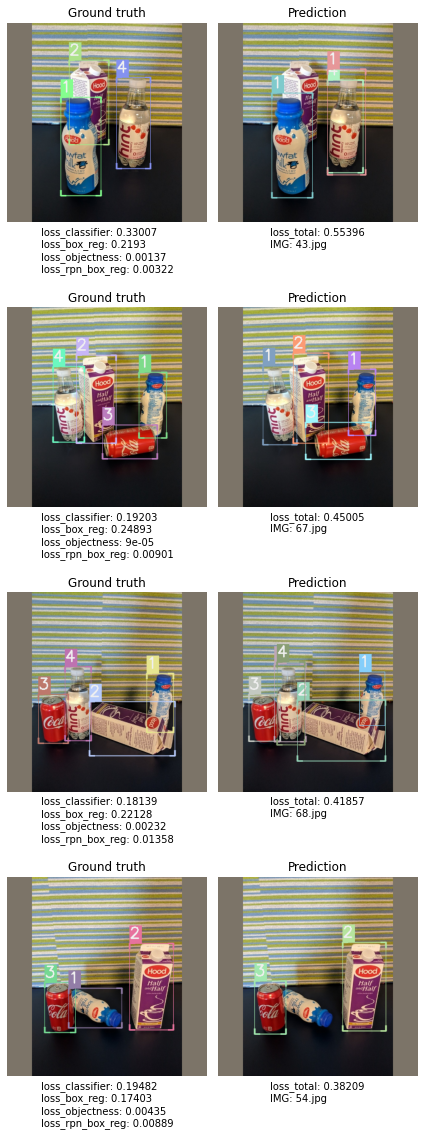

In [11]:
samples_plus_losses, preds, losses_stats = faster_rcnn.interp.plot_top_losses(model=model, dataset=valid_ds, sort_by="loss_total", n_samples=4)

INFO     - Losses returned by model: ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'] | icevision.models.interpretation:plot_top_losses:195


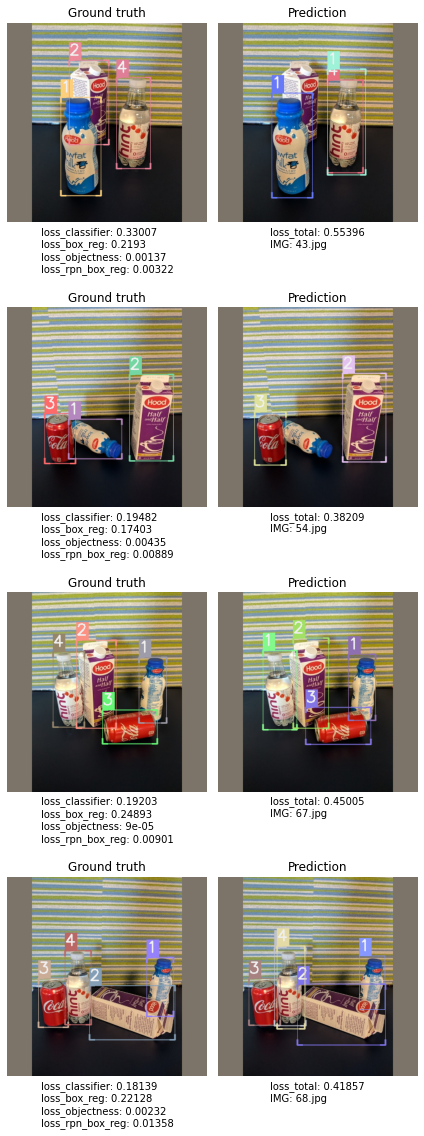

In [12]:
samples_plus_losses, preds, losses_stats = faster_rcnn.interp.plot_top_losses(model=model, dataset=valid_ds, sort_by="loss_classifier", n_samples=4)

INFO     - Losses returned by model: ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'] | icevision.models.interpretation:plot_top_losses:195


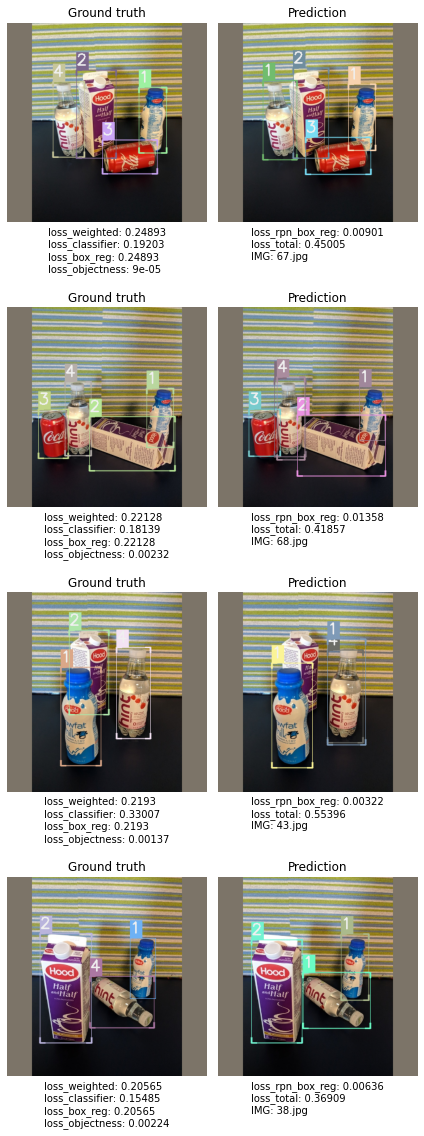

In [13]:
# in this case `loss_weighted` will be equal to `loss_box_reg`
by = {
        "method": "weighted",
        "weights": {
            "loss_box_reg": 1,
            "loss_classifier": 0,
            "loss_objectness": 0,
            "loss_rpn_box_reg": 0,
        },
    }

samples_plus_losses, preds, losses_stats = faster_rcnn.interp.plot_top_losses(model=model, dataset=valid_ds, sort_by=by, n_samples=4)

INFO     - Losses returned by model: ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'] | icevision.models.interpretation:plot_top_losses:195


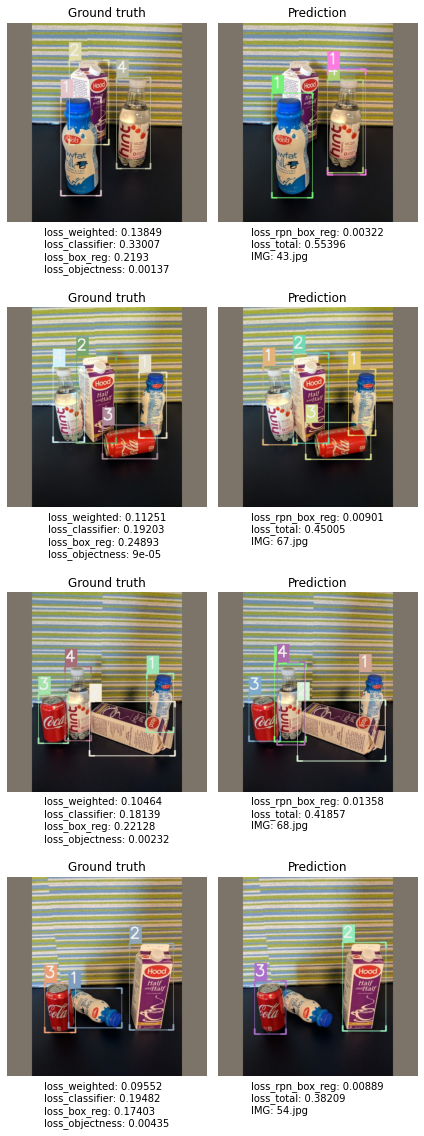

In [14]:
by = {
        "method": "weighted",
        "weights": {
            "loss_box_reg": 0.25,
            "loss_classifier": 0.25,
            "loss_objectness": 0.25,
            "loss_rpn_box_reg": 0.25,
        },
    }

samples_plus_losses, preds, losses_stats = faster_rcnn.interp.plot_top_losses(model=model, dataset=valid_ds, sort_by=by, n_samples=4)

In [15]:
# `losses_stats` contains useful statistics for each computed loss in the dataset
losses_stats

{'loss_box_reg': {'1ile': 0.04792136326432228,
  '25ile': 0.08809038251638412,
  '50ile': 0.12821757793426514,
  '75ile': 0.18786406517028809,
  '99ile': 0.24892622232437134,
  'max': 0.24892622232437134,
  'mean': 0.13616644748701498,
  'min': 0.04792136326432228},
 'loss_classifier': {'1ile': 0.03467537462711334,
  '25ile': 0.053794343024492264,
  '50ile': 0.1069008931517601,
  '75ile': 0.14782828092575073,
  '99ile': 0.3300709128379822,
  'max': 0.3300709128379822,
  'mean': 0.11171098683889095,
  'min': 0.03467537462711334},
 'loss_objectness': {'1ile': 4.237781467963941e-06,
  '25ile': 0.00010930869757430628,
  '50ile': 0.0003832672373391688,
  '75ile': 0.0022352994419634342,
  '99ile': 0.014762872830033302,
  'max': 0.014762872830033302,
  'mean': 0.0016306210929122665,
  'min': 4.237781467963941e-06},
 'loss_rpn_box_reg': {'1ile': 0.00031744109583087265,
  '25ile': 0.003448374569416046,
  '50ile': 0.006361859384924173,
  '75ile': 0.008889082819223404,
  '99ile': 0.01792091876268

In [17]:
# we can easily extract losses per image and display them in a pandas DataFrame for further analysis

import pandas as pd

loss_per_image = get_samples_losses(samples_plus_losses)
pd.DataFrame(loss_per_image)

,filepath,loss_classifier,loss_box_reg,loss_objectness,loss_rpn_box_reg,loss_total,loss_weighted
0,/root/.icevision/data/fridge/odFridgeObjects/images/43.jpg,0.330071,0.219305,0.001368,0.003219,0.553962,0.138491
1,/root/.icevision/data/fridge/odFridgeObjects/images/67.jpg,0.192033,0.248926,0.000087,0.009008,0.450054,0.112514
2,/root/.icevision/data/fridge/odFridgeObjects/images/68.jpg,0.181392,0.221283,0.002316,0.013578,0.418568,0.104642
3,/root/.icevision/data/fridge/odFridgeObjects/images/54.jpg,0.194818,0.174027,0.004354,0.008889,0.382088,0.095522
4,/root/.icevision/data/fridge/odFridgeObjects/images/38.jpg,0.154846,0.205650,0.002235,0.006356,0.369087,0.092272
5,/root/.icevision/data/fridge/odFridgeObjects/images/72.jpg,0.134002,0.195150,0.000474,0.017323,0.346950,0.086738
6,/root/.icevision/data/fridge/odFridgeObjects/images/89.jpg,0.147828,0.187864,0.000085,0.005891,0.341668,0.085417
7,/root/.icevision/data/fridge/odFridgeObjects/images/69.jpg,0.127614,0.203392,0.000545,0.007822,0.339373,0.084843
8,/root/.icevision/data/fridge/odFridgeObjects/images/40.jpg,0.156380,0.159127,0.000109,0.005086,0.320702,0.080176
9,/root/.icevision/data/fridge/odFridgeObjects/images/45.jpg,0.141121,0.147064,0.002866,0.017921,0.308971,0.077243


## Run `top_plot_losses` on a `retinanet` pretrained (but not finetuned) model

In [18]:
model = retinanet.model(num_classes=len(class_map))

Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth


INFO     - Losses returned by model: ['loss_classification', 'loss_bbox_regression'] | icevision.models.interpretation:plot_top_losses:195


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


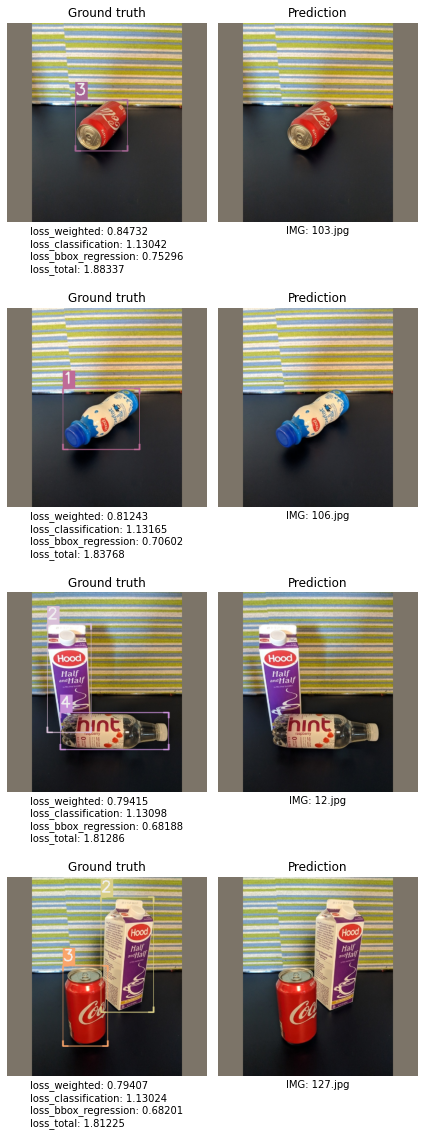

In [19]:
by = {"method": "weighted", 
      "weights": {"loss_classification": 0.25,
                "loss_bbox_regression": 0.75,
                }
        }

sorted_samples, sorted_preds, losses_stats = retinanet.interp.plot_top_losses(model, valid_ds, sort_by=by, n_samples=4)

## Run `top_plot_losses` on a `efficientdet` pretrained (but not finetuned) model

In [21]:
model = efficientdet.model(model_name='tf_efficientdet_lite0', num_classes=len(class_map), img_size=384)

INFO     - Losses returned by model: ['loss', 'class_loss', 'box_loss'] | icevision.models.interpretation:plot_top_losses:195


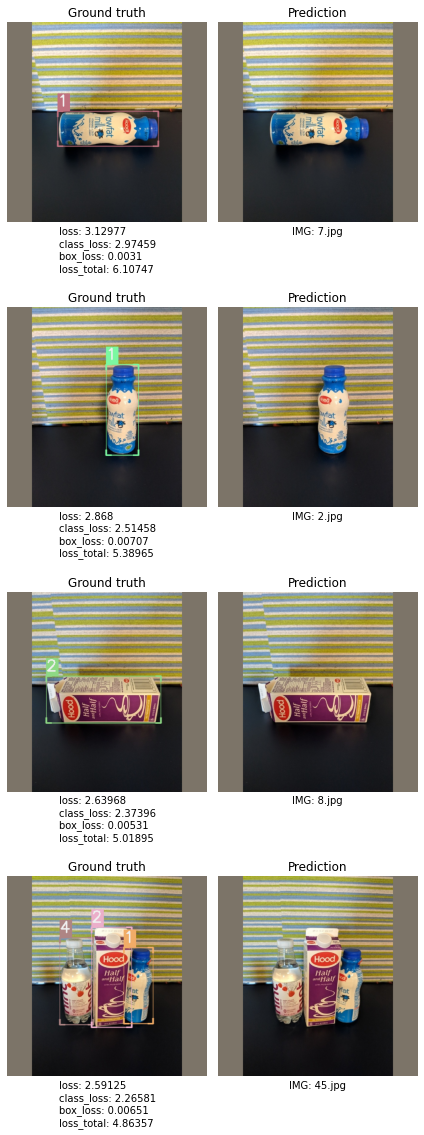

In [22]:
sorted_samples, sorted_preds, losses_stats = efficientdet.interp.plot_top_losses(model, valid_ds, sort_by="class_loss", n_samples=4)

# Instance Segmentation

## `plot_top_losses` in action with a `mask_rcnn` model on the `pennfudan` dataset

In [23]:
data_dir = icedata.pennfudan.load_data()
class_map = icedata.pennfudan.class_map()

In [24]:
parser = icedata.pennfudan.parser(data_dir)

train_records, valid_records = parser.parse()

shift_scale_rotate = tfms.A.ShiftScaleRotate(rotate_limit=10)
crop_fn = partial(tfms.A.RandomSizedCrop, min_max_height=(384//2, 384), p=.5)
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=348), tfms.A.Normalize()])
train_tfms = tfms.A.Adapter(
    [
        *tfms.A.aug_tfms(size=384, presize=512, shift_scale_rotate=shift_scale_rotate, crop_fn=crop_fn),
        tfms.A.Normalize(),
    ]
)

train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

train_dl = mask_rcnn.train_dl(train_ds, batch_size=1, shuffle=True, num_workers=0)
valid_dl = mask_rcnn.valid_dl(valid_ds, batch_size=1, shuffle=False, num_workers=0)

INFO     - Autofixing records | icevision.parsers.parser:parse:126


In [25]:
model = mask_rcnn.model(num_classes=len(class_map))

learn = mask_rcnn.fastai.learner(dls=[train_dl, valid_dl], model=model)
learn.fine_tune(10, 5e-4, freeze_epochs=2)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


epoch,train_loss,valid_loss,time
0,0.565102,0.541098,00:23
1,0.817718,0.592045,00:18


epoch,train_loss,valid_loss,time
0,0.414319,0.343012,00:26
1,0.437748,0.418022,00:24
2,0.453333,0.386358,00:24
3,0.412527,0.334770,00:24
4,0.406474,0.349783,00:24
5,0.367746,0.328585,00:24
6,0.389905,0.349505,00:24
7,0.298222,0.314676,00:24
8,0.328545,0.311327,00:24
9,0.305414,0.306372,00:24


INFO     - Losses returned by model: ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg', 'loss_mask'] | icevision.models.interpretation:plot_top_losses:195


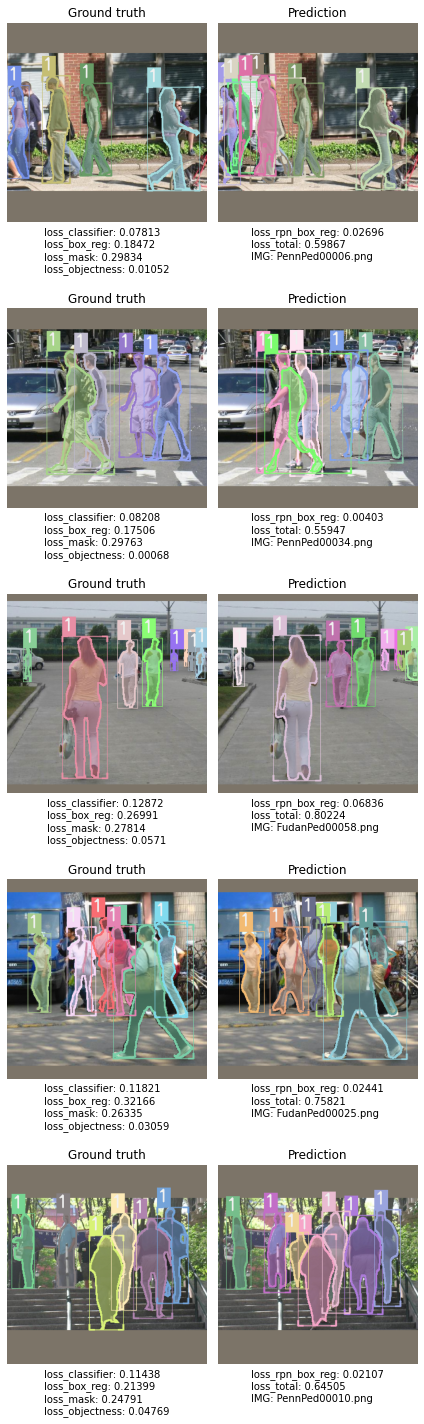

In [26]:
sorted_samples, sorted_preds, losses_stats = mask_rcnn.interp.plot_top_losses(model, valid_ds, sort_by="loss_mask")

# Keypoint Detection

## `plot_top_losses` in action with a `keypoint_rcnn` model on the `biwi` dataset

In [27]:
data_dir = icedata.biwi.load_data()
parser = icedata.biwi.parser(data_dir)

train_records, valid_records = parser.parse()

presize = 240
size = 120

valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size), tfms.A.Normalize()])
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize, crop_fn=None), tfms.A.Normalize()])

train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

train_dl = keypoint_rcnn.train_dl(train_ds, batch_size=32, num_workers=4, shuffle=True)
valid_dl = keypoint_rcnn.valid_dl(train_ds, batch_size=32, num_workers=4, shuffle=False)

INFO     - Autofixing records | icevision.parsers.parser:parse:126


In [28]:
backbone = backbones.resnet_fpn.resnet18(pretrained=True)
model = keypoint_rcnn.model(backbone=backbone, num_keypoints=1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [29]:
learn = keypoint_rcnn.fastai.learner(dls=[train_dl, valid_dl], model=model)
learn.fine_tune(5, 1e-4, freeze_epochs=2)

epoch,train_loss,valid_loss,time
0,9.186475,8.357777,00:55
1,8.404591,7.145662,00:25


epoch,train_loss,valid_loss,time
0,6.787796,6.447759,00:37
1,6.470535,5.708456,00:28
2,6.066651,5.154649,00:23
3,5.783560,4.866782,00:22
4,5.566287,4.919517,00:28


INFO     - Losses returned by model: ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg', 'loss_keypoint'] | icevision.models.interpretation:plot_top_losses:195


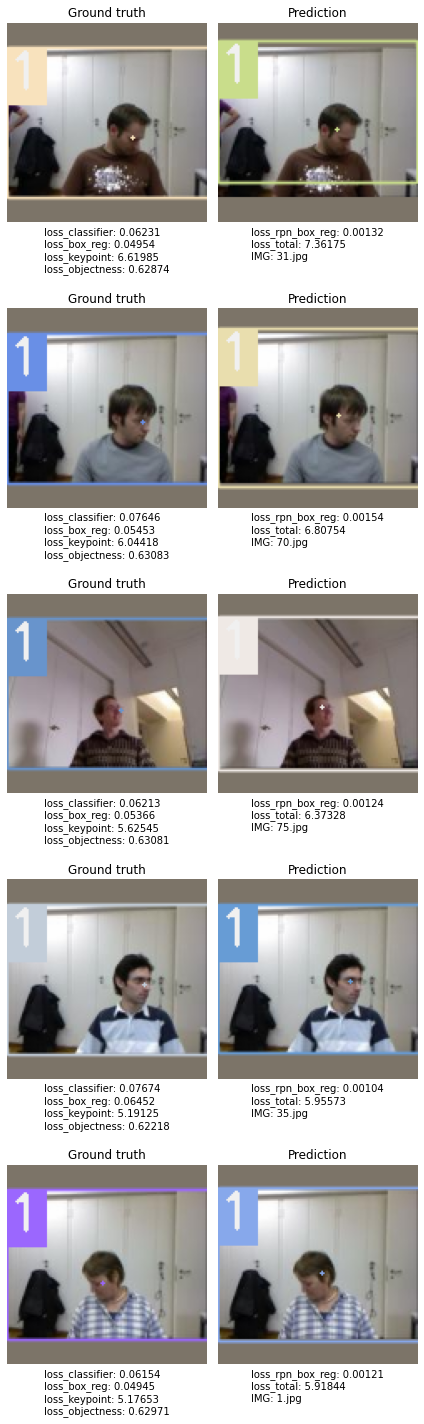

In [30]:
sorted_samples, sorted_preds, losses_stats = keypoint_rcnn.interp.plot_top_losses(model, valid_ds, sort_by="loss_keypoint")